In [1]:
#Dependancies
%matplotlib inline
import matplotlib
import requests
import pandas as pd
import numpy as np
import json
import csv
#from pandas_profiling import ProfileReport
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
import os
import seaborn as sb
import matplotlib.pyplot as plt
from config import college_scorecard_api_key
import scipy.stats as stats


***
## Data Cleanup

In [2]:
# Call in 'College Scorecard (i.e. csc)' API ; only schools that offer a bachelor's or graduate degree
csc_url = "https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.highest=3,4&"

csc_2017_query_url = f'{csc_url}api_key={college_scorecard_api_key}&_fields=id,school.name,school.city,school.ownership,school.state_fips,school.zip,location.lat,location.lon,2017'
csc_2017_response = requests.get(csc_2017_query_url).json()

# Identify JSON page number
csc_json_data = []

# Loop through each JSON page and extract JSON data into a list
for page in range(0, 29):
    csc_2017_response = requests.get(csc_2017_query_url, params={'page': page, 'per_page': 100}).json()
    csc_json_data.append(csc_2017_response['results'])

    csc_data_list = []
    for csc_data in csc_json_data:
        for csc_objects in csc_data:
            csc_data_list.append(csc_objects)

# Convert JSON list into a Dataframe
csc_data_frame = pd.DataFrame(csc_data_list)


In [3]:
# Pull columns needed
csc_data_table_pull = csc_data_frame[['school.name',
                                     'school.city',
                                     'school.ownership',
                                     'school.state_fips',
                                     'location.lat',
                                     'location.lon',
                                     '2017.student.size',
                                     '2017.cost.attendance.academic_year',
                                     '2017.cost.tuition.in_state',
                                     '2017.cost.tuition.out_of_state',
                                     '2017.student.retention_rate.four_year.full_time',
                                     '2017.aid.federal_loan_rate',
                                     '2017.aid.loan_principal',
                                     '2017.aid.median_debt.completers.overall',
                                     '2017.aid.median_debt.income.0_30000',
                                     '2017.aid.median_debt.income.30001_75000',
                                     '2017.aid.median_debt.income.greater_than_75000',
                                     '2017.aid.median_debt.female_students',
                                     '2017.aid.median_debt.male_students',
                                     '2017.completion.rate_suppressed.overall',
                                     '2017.aid.median_debt.dependent_students',
                                     '2017.aid.median_debt.independent_students']].dropna().reset_index(drop=True)

# Clean column headers
csc_data_table_header_clean = csc_data_table_pull.rename(columns = {'school.name': 'School Name',
                                                                  'school.city': 'City',
                                                                  'school.state_fips': 'State Code',
                                                                  'school.ownership': 'Institution',
                                                                  'location.lat': 'Latitude',
                                                                  'location.lon': 'Longitude',
                                                                  '2017.student.size': 'Student Size',
                                                                  '2017.cost.attendance.academic_year': 'Cost of Attendance',
                                                                  '2017.cost.tuition.in_state': 'In-State Tuition',
                                                                  '2017.cost.tuition.out_of_state': 'Out-of-State Tuition',
                                                                  '2017.student.retention_rate.four_year.full_time': 'Retention Rate: Fulltime Student',
                                                                  '2017.aid.federal_loan_rate': '% of Undergrad Students Recieving Fed Student Loan',
                                                                  '2017.aid.loan_principal': 'Median Loan Principal',
                                                                  '2017.aid.median_debt.completers.overall': 'Median Debt',
                                                                  '2017.aid.median_debt.income.0_30000': 'Median Debt with income between 0-30k',
                                                                  '2017.aid.median_debt.income.30001_75000': 'Median Debt with income between 30,001-75k',
                                                                  '2017.aid.median_debt.income.greater_than_75000': 'Median Debt with income greater than 75k',
                                                                  '2017.aid.median_debt.female_students': 'Median Debt for Female Students',
                                                                  '2017.aid.median_debt.male_students': 'Median Debt for Male Students',
                                                                  '2017.completion.rate_suppressed.overall': 'Completion Rate',
                                                                   '2017.aid.median_debt.dependent_students': "Median Debt for Dependent Students",
                                                                   '2017.aid.median_debt.independent_students': 'Median Debt for Independent Students'})


In [4]:
# Pull in and merge State names.

fips_path = "Resources/State FIPS Codes.csv"
fips_states_df = pd.read_csv(fips_path)

csc_data_final = pd.merge(csc_data_table_header_clean, fips_states_df, on='State Code')

***
## Question 1: Why does Alabama have the highest avg. median debt per capita?
**Team Member:** Henock Yacob

After going through the data exploration and clean-up process I wanted to begin comparing the data sets at the state level. My initial approach was to run a correlation test for median debt and cost of attendance, however it showed that very little correlation existed. So I decided to take a different approach to the data comparison.

In [5]:
csc_data_50_states = csc_data_final.loc[csc_data_final["State Name"] != 'District of Columbia', :]
#csc_data_50_states

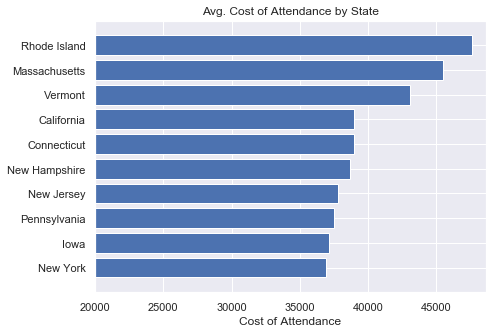

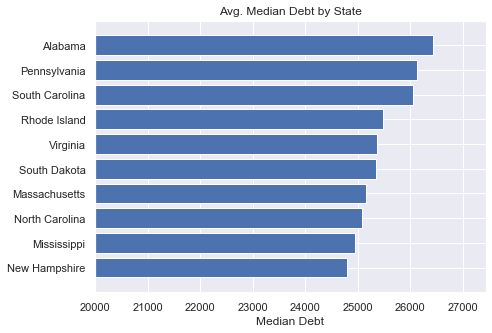

In [6]:
# Group by State - Averages
csc_grouped_data = csc_data_50_states.groupby(['State Name']).mean()

# Avg. Cost of Attendance by State
csc_sorted_data_ca = csc_grouped_data.sort_values('Cost of Attendance', ascending = False)
avg_ca_by_state = csc_sorted_data_ca['Cost of Attendance'].reset_index()
top_ten_avg_ca_by_state = avg_ca_by_state.head(10)

fig, ax = plt.subplots(figsize = (7, 5))

state_names_x = top_ten_avg_ca_by_state['State Name'].tolist()
ca_debt_y = top_ten_avg_ca_by_state['Cost of Attendance'].tolist()
y_pos = np.arange(len(state_names_x))

ax.barh(y_pos, ca_debt_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(state_names_x)
ax.invert_yaxis() 
ax.set_xlabel('Cost of Attendance')
ax.set_title('Avg. Cost of Attendance by State')
plt.xlim(20000, max(ca_debt_y)+1000)
plt.ylim(10, -1)
plt.savefig("outputs/cost_by_state.png")

# Avg. Median Debt by State
csc_sorted_data_md = csc_grouped_data.sort_values('Median Debt', ascending = False)
avg_md_state = csc_sorted_data_md['Median Debt'].reset_index()
top_ten_avg_md_by_state = avg_md_state.head(10)

fig, ax = plt.subplots(figsize = (7, 5))

state_names_x = top_ten_avg_md_by_state['State Name'].tolist()
md_debt_y = top_ten_avg_md_by_state['Median Debt'].tolist()
y_pos = np.arange(len(state_names_x))

ax.barh(y_pos, md_debt_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(state_names_x)
ax.invert_yaxis() 
ax.set_xlabel('Median Debt')
ax.set_title('Avg. Median Debt by State')
plt.xlim(20000, max(md_debt_y)+1000)
plt.ylim(10, -1)
plt.savefig("outputs/debt_by_state.png")

#### Compared Top 10 States by Avg. Median Debt and Avg. Cost of Attendance

I placed both data sets in a horizontal bar chart and sorted from highest to lowest, and I observed that the state with the highest median debt was also not the highest in avg. cost of attendance. In this case the two anomalies were Alabama (i.e. highest median debt) and Rhode Island (highest cost of attendance). 

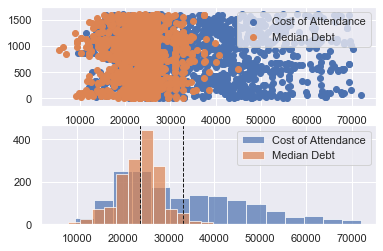

In [7]:
# Poulation data for t-Test

csc_ca_population = csc_data_final['Cost of Attendance']
csc_md_population = csc_data_final['Median Debt']

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(csc_ca_population, range(len(csc_ca_population)), label="Cost of Attendance")
plt.scatter(csc_md_population, range(len(csc_md_population)), label="Median Debt")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(csc_ca_population, 15, density=False, alpha=0.7, label="Cost of Attendance")
plt.hist(csc_md_population, 15, density=False, alpha=0.7, label="Median Debt")
plt.axvline(csc_ca_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(csc_md_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend() 
plt.savefig("outputs/cost_to_debt_t_test.png")

In [8]:
stats.ttest_ind(csc_ca_population, csc_md_population, equal_var=False)

Ttest_indResult(statistic=26.324676764197232, pvalue=1.908233094975252e-131)

#### t-Test

Before I went any further I ran a t-test to see how well my data sets were distributed. The avg. median debt data had a normal distribution, while the avg. cost of attendance data had a bi-modal distribution. This indicated that a good portion of the data had schools where a high cost of attendance and low median debt existed. In other words, as school costs increased, median debt stayed relativly the same (i.e. between 20k and 30k).

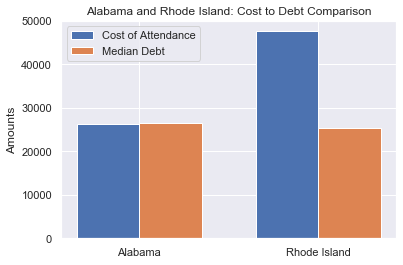

In [9]:
csc_al_and_ri_analysis = csc_data_50_states.groupby(['State Name']).mean()
csc_al_and_ri_summary = csc_al_and_ri_analysis.loc[['Alabama', 'Rhode Island']].reset_index()


ca_and_md_data = csc_al_and_ri_summary[['State Name', 'Cost of Attendance', 'Median Debt']]
state_al_and_ri = ca_and_md_data['State Name'].tolist()
ca_al_and_ri = ca_and_md_data['Cost of Attendance'].tolist()
md_al_and_ri = ca_and_md_data['Median Debt'].tolist()

x = np.arange(len(state_al_and_ri))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ca_al_and_ri, width, label='Cost of Attendance')
rects2 = ax.bar(x + width/2, md_al_and_ri, width, label='Median Debt')

ax.set_ylabel('Amounts')
ax.set_title('Alabama and Rhode Island: Cost to Debt Comparison')
ax.set_xticks(x)
ax.set_xticklabels(state_al_and_ri)
ax.legend()
plt.savefig("outputs/al_ri_cost_to_debt_compare.png")

#### Compared the top states in both categories.

After the t-Test i decided to visualize the top states in both categories to compare thier values. This perspective clearly shows that there is trend among schools with high attendance costs and schools with low attendance costs.

#### Key Findings:
* Students that attended more expensive schools may have had additional forms of funding to help cover the costs of attendance.
* Its possible that students that were closer to the poverty line, had a cost to debt ratio closer to 1. Meaning all of the debt is utilizaed towards the costs of attendence. Conversely, higher costs schools will show proportionaly lower median debt.

### Henock's Code - End

----------------------------------------------

### JJ's Code - Start

# Calculate the average median debt of each family income category for each institutional type?

In [10]:
# rename the institution values and insert into the dataframe
csc_data_final.Institution.replace(to_replace = {1: 'Public', 2: 'Private Nonprofit', 3: 'Private For-Profit'}, inplace = True)

csc_data_final['Institution'] = pd.Categorical(csc_data_final.Institution, categories = ['Public', 'Private Nonprofit', 
                                                                                     'Private For-Profit'],
                                    ordered = False)

In [11]:
csc_data_final['Institution'].value_counts()


Private Nonprofit     873
Public                579
Private For-Profit    161
Name: Institution, dtype: int64

In [12]:
  
# 0 -30k - The number of students in the median debt low-income (less than or equal to $30,000 in nominal family income) students cohort
# 30 -75K - The number of students in the median debt middle-income (between $30,000 and $75,000 in nominal family income) students cohort
# 75K or greater - The number of students in the median debt high-income (above $75,000 in nominal family income) students cohort

avg_median_debt_pd = csc_data_final[["Institution", "Median Debt with income between 0-30k", 
                                    "Median Debt with income between 30,001-75k",
                                   "Median Debt with income greater than 75k" ]]


In [13]:
# group the institution type

group_avg_median_debt_pd =round( avg_median_debt_pd.groupby("Institution").mean(), 2)
group_avg_median_debt_pd

,Median Debt with income between 0-30k,"Median Debt with income between 30,001-75k",Median Debt with income greater than 75k
Institution,,,
Public,14891.60,15126.70,14565.27
Private Nonprofit,17021.19,17894.03,17116.40
Private For-Profit,13789.24,17139.90,16761.32


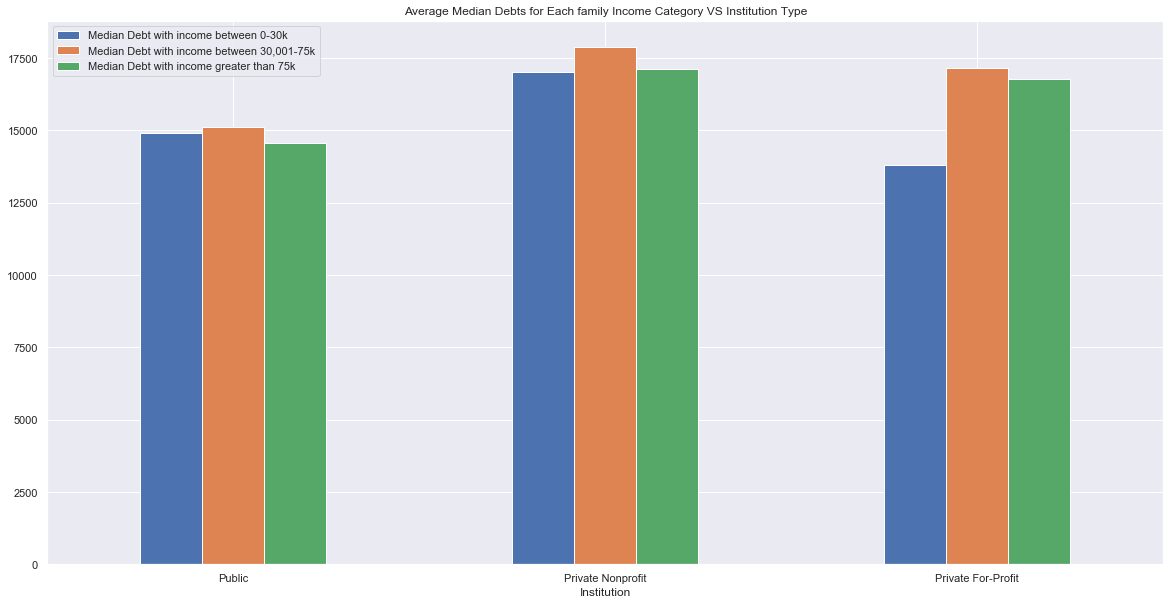

In [14]:
# Plot the graph
group_avg_median_debt_pd.plot(kind = 'bar',  rot=0,
             figsize = (20,10))
           

plt.title('Average Median Debts for Each family Income Category VS Institution Type')
#save the figure
plt.savefig("Resources/DebtFamilyIncVSInst.png")

From the result, we found that students from private schools have the highest median debt out of the three school types. Within each school type, students with family income ranging from \$30,000-\$70,001 (shown in the orange) have the highest median debt out of the three income groups.

In [15]:
male_fem_median_debt_pd = csc_data_final[["Institution", "Median Debt for Female Students", "Median Debt for Male Students"]]


In [16]:
gp_avg_male_fem_median_debt_pd =round( male_fem_median_debt_pd.groupby("Institution").mean(), 2)
gp_avg_male_fem_median_debt_pd

,Median Debt for Female Students,Median Debt for Male Students
Institution,,
Public,15237.60,14323.18
Private Nonprofit,17974.23,16497.14
Private For-Profit,14685.58,14805.69


# Calculate the average median debt of Male and Female Students Vs each institutional type?

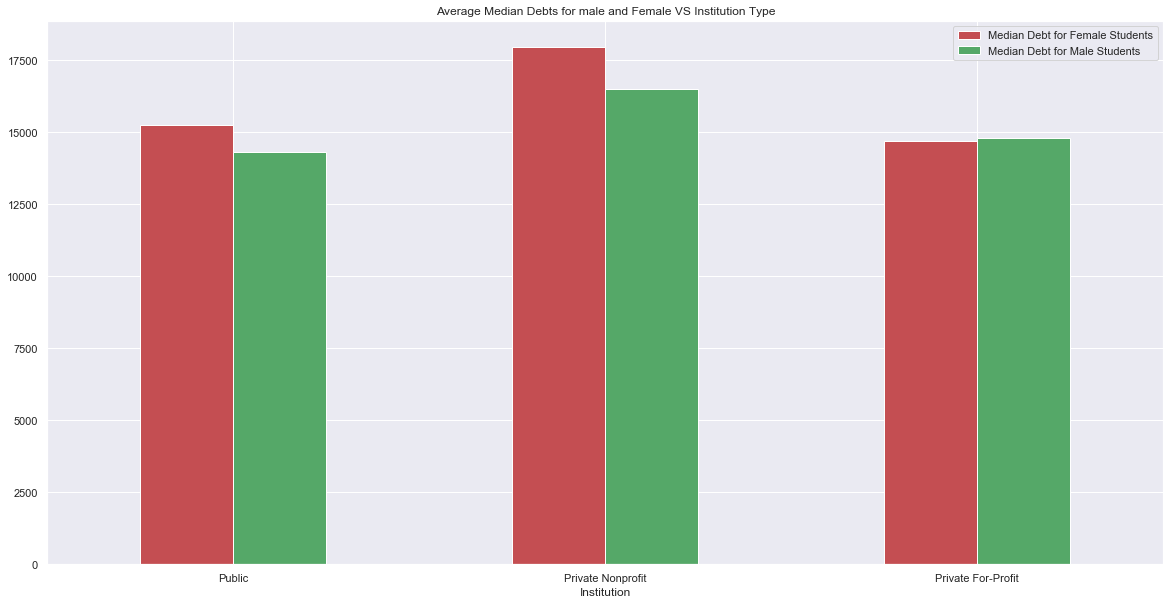

In [17]:
# Plot the graphs

gp_avg_male_fem_median_debt_pd.plot(kind = 'bar',  rot=0, color='rg', 
             figsize = (20,10))
           



plt.title('Average Median Debts for male and Female VS Institution Type')
#save the figure
plt.savefig("Resources/DebtMaleFemaleVSInst.png")

we can see that the average median debts for female is higher in both public and private institution where in private fro profit it is slightly lower

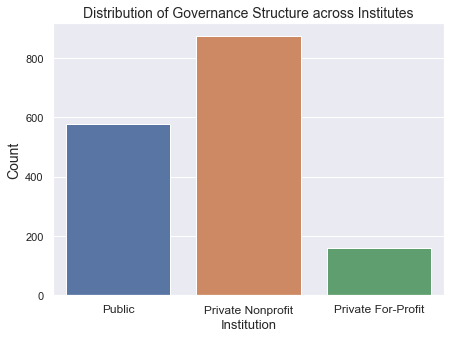

In [18]:
# most common type of governance structure in the US across institutes?
# plot
plt.figure(figsize = (7, 5))
sb.countplot(data = csc_data_final, x = 'Institution')

# annotate
n_points = csc_data_final.shape[0]
cat_counts = csc_data_final.Institution.value_counts()
locs, labels = plt.xticks()                # get current tick locations and labels

    
# label
plt.title('Distribution of Governance Structure across Institutes', fontsize = 14)
plt.xticks(fontsize = 12)
plt.xlabel("Institution", fontsize = 13)
plt.ylabel('Count', fontsize = 14);

plt.savefig("Resources/MostCommonStructure.png")

### JJ's Code - End

----------------------------------------------

### Ana's Code - Start

According to the latest student loan debt statistics, student loan debt is now the second highest consumer debt category - second only to mortgages and higher than credit card debt. There are more than 44 million borrowers who collectively owe 1.6 trillion in student loan debt.
After going through the data exploration and clean-up process I wanted to begin comparing the data sets at the state level- by sex, age and location.
I took a look at how that debt is geographically distributed across the US. The Department of Education's Office for Federal Student Aid publishes quarterly student debt totals and the number of borrowers for each state. Using that data, I found the total student-debt median in each state, along with the median per gender of barrowers.

In [19]:
plt.close()

### Which is the gender distribution of the Median Debt per gender and per state?

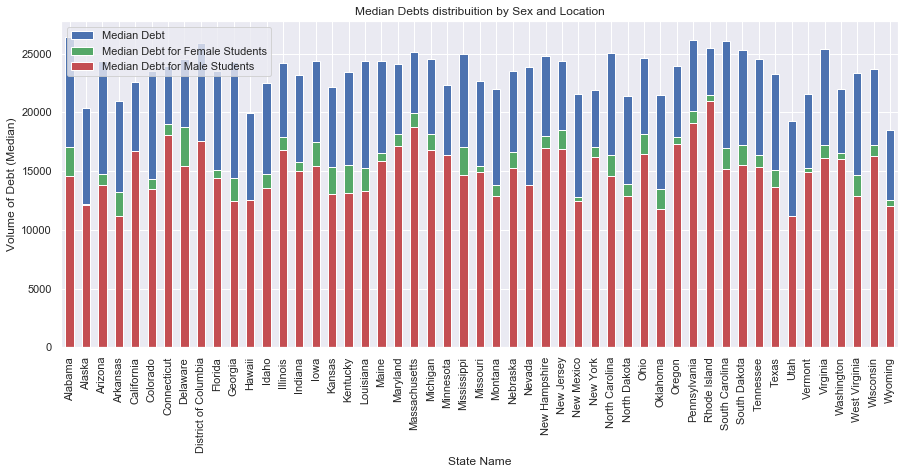

<Figure size 432x288 with 0 Axes>

In [20]:
#Read the columns we need for building a plot
csc_data_finaly =pd.DataFrame(csc_data_final.groupby(['State Name'])['Median Debt', 'Median Debt for Female Students', 'Median Debt for Male Students' ].mean())
csc_data_finaly =csc_data_finaly.reset_index()

#plot
ax = csc_data_finaly.plot(x="State Name", y="Median Debt", kind="bar",figsize=(15,6))
csc_data_finaly.plot(x="State Name", y="Median Debt for Female Students", kind="bar", ax=ax, color="C2")
csc_data_finaly.plot(x="State Name", y="Median Debt for Male Students", kind="bar", ax=ax, color="C3")
plt.title('Median Debts distribuition by Sex and Location')
plt.ylabel('Volume of Debt (Median)');


plt.show()
plt.savefig('outputs/MedianFemalMale.png')

This plot is showing that nationally there are more women with debt than men. Also,In 52 states, the average debt is more than $20,000 bilion . Alabama residents owe 26.7 billion dollars in student loan debt on avarage. Alaska residents, for example, owe less than 20 billion in student loan debt on avarage.



#### What is the T-test for 'Median Debd'?
#### The Ho is : The population and the sample of the population have equal avarages of Median Debd

In [21]:

# Generate some data to test with
def gendata(loc=0):
    population = csc_data_final['Median Debt']
    sample = population.sample(frac =.25) 
    
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population)), population, label="population")
    plt.scatter(range(len(sample)), sample, label="sample")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population, 20, density=True, alpha=0.7, label="population")
    plt.hist(sample, 20, density=True, alpha=0.7, label="sample")
    plt.axvline(population.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(sample.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return population, sample

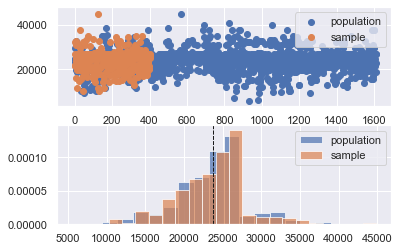

In [22]:
# Generate some data and show the scatter plot
population, sample = gendata()
#plt.show()
plt.savefig('outputs/T-test1.png')

In [23]:
stats.ttest_1samp(sample, population.mean())

Ttest_1sampResult(statistic=-0.21096000681021715, pvalue=0.8330253747090366)

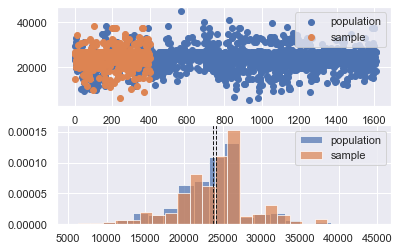

In [24]:
# Generate data with a bigger difference in means
population, sample = gendata(loc=10000)
plt.savefig('outputs/T-test2.png')

In [25]:
stats.ttest_1samp(sample, population.mean())

Ttest_1sampResult(statistic=1.6396839558568064, pvalue=0.10185315372550356)

#### This is a two-sided test for the null hypothesis that the expected value (mean) of a sample of independent observations a is equal to the given population mean. p_value> 0.05. We fail to reject the null hypothesis.

In [26]:
plt.close()

In [27]:
plt.close()

### Which is the distribution of student debt by Age and Location?

In [ ]:
#Portfolio-by-Location-by-Age
data5_df = pd.read_csv("Resources/Portfolio-by-Location-by-Age.csv")
data5_df.rename(columns = {' ' : 'Location',
                              '24 - Younger':'24 or Younger Dollars Outstanding (in billions)',
                              'Unnamed: 2':'24 or Younger Barrowers(#)(in millions)',
                              '25 -34' :'25 to 34 Dollars Outstanding(in billions)',
                              'Unnamed: 4' :'25 to 34 Barrowers(#)(in millions)',
                              '35 - 49' :'35 to 49 Dollars Outstanding(in billions)',
                              'Unnamed: 6' :'35 to 49 Barrowers(#)(in millions)',
                              '50 -61' :'50 to 61 Dollars Outstanding(in billions)',
                              'Unnamed: 8' :'50 to 61 Barrowers(#)(in millions)',
                              '62 - Older' :'62+Dollars Outstanding(in billions)',
                              'Unnamed: 10' :'62+Barrowers(#)(in millions)'
                              }, inplace = True)
data5_df = data5_df.drop(data5_df.index[0])
data5_df = data5_df.drop(data5_df.index[53])
data = list(data5_df.columns.values)
#print(data[1:])
data5_df[data[1:]]
data5_df[data[1:]] = data5_df[data[1:]].replace('[\$,]','', regex=True).astype(float)
data5_df = data5_df.drop(data5_df.index[52])
data5_df.tail()
ax = data5_df.plot(x="Location", y="24 or Younger Dollars Outstanding (in billions)", kind="bar",figsize=(16,4))
data5_df.plot(x="Location", y="25 to 34 Dollars Outstanding(in billions)", kind="bar", ax=ax, color="C2")
data5_df.plot(x="Location", y="35 to 49 Dollars Outstanding(in billions)", kind="bar", ax=ax, color="C3")
data5_df.plot(x="Location", y="50 to 61 Dollars Outstanding(in billions)", kind="bar", ax=ax, color="C4")
data5_df.plot(x="Location", y="62+Dollars Outstanding(in billions)", kind="bar", ax=ax, color="C5")
plt.title('Median Debts by Age and Location')
plt.ylabel('Volume of Debt (Median) in billions');
plt.savefig('outputs/DollarsOutstandindByAgeLocation.png')
plt.show()

-While student loan debt is often thought of as a problem disproportionately affecting millennials, most student loan debt (57.8%) is held by borrowers 35 and older. The chart above shows that borrowers 35 to 61 tend to have the highest loan balances.
-Although borrowers 24 and younger have the lowest average loan balances ($14,298) of any age group, many are still enrolled in school and taking out additional loans. 

-Five states with the most student debt in total are: California, Texas, New York, Florida, and Georgia. On the flip side, Wyoming has the least debt in total (3,610 dollars), which is 33.0 lower than the national average.Hawaii follows right behind at (3,780 billions dollars), and 29.9% below the national average.

### What will the Data show if I will choose only 5 states?

After having a nationl picture of the Student Loan distribuition, I was curious to compare the amount of debt reported to the population for Minnensota and some other states that have a high amount of Student Debt (as California, Texas and New York) and states with lowest amount of Student Debt (respectivley, I choosed Rhode Island).

In [31]:
data1_df = pd.read_csv("Resources/5StatesData.csv")
data1_df = data1_df.dropna()
data1_df.tail()

,Name,Year,Average debt of graduates,Percent of graduates with debt,Per capita debt of graduates,Average debt of graduates in federal loans,Percent of graduates borrowing federal loans,Per capita federal debt of graduates,"Federal debt of graduates, as percent of total debt",Per capita nonfederal debt of graduates,"Nonfederal debt of graduates, as percent of total debt"
70,Rhode Island - Total,2011-12,30483.0,0.69,21001.0,21383.0,0.67,14334.0,0.68,6667.0,0.32
71,Rhode Island - Total,2010-11,29097.0,0.69,20195.0,20544.0,0.67,13801.0,0.68,6394.0,0.32
72,Rhode Island - Total,2009-10,26340.0,0.67,17587.0,19447.0,0.63,12345.0,0.70,5242.0,0.30
73,Rhode Island - Total,2008-09,26573.0,0.65,17404.0,18437.0,0.63,11655.0,0.67,5749.0,0.33
74,Rhode Island - Total,2007-08,25831.0,0.71,18231.0,18079.0,0.68,12317.0,0.68,5914.0,0.32


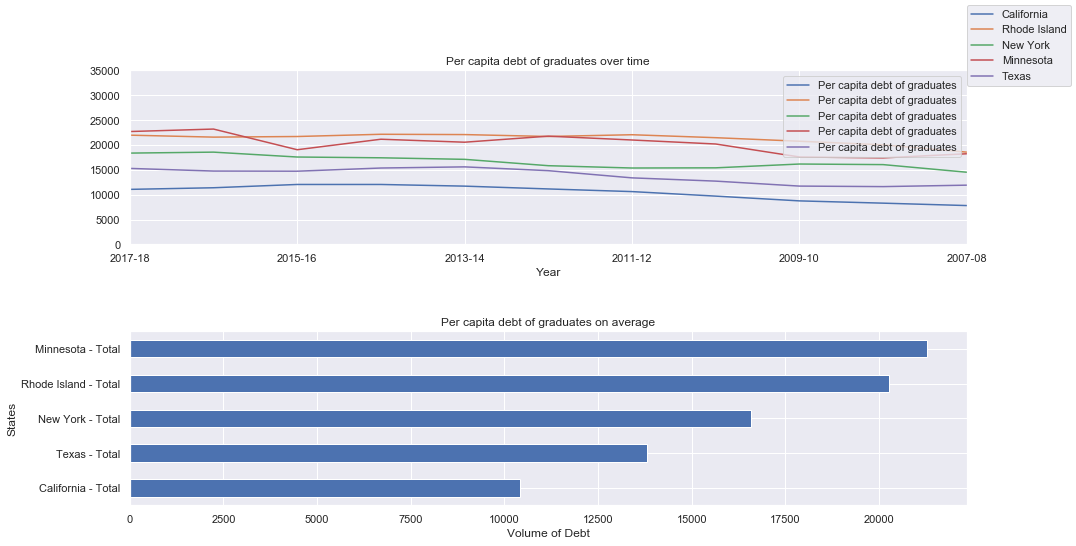

In [37]:
#Per capita debt of graduates over time
fig = plt.figure()
# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(211)
# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(212)
#Line plot 
data1_df.groupby('Name').plot(x='Year', y='Per capita debt of graduates', ax=ax1, figsize= (15,8))
ax1.set_ylim((0,35000))
ax1.xaxis.set_label_text("Year")
ax1.set_title("Per capita debt of graduates over time")
fig.legend(['California', 'Rhode Island', 'New York','Minnesota','Texas'],
           loc='upper right')
#Bar Plot
data1_df.groupby('Name')['Per capita debt of graduates'].mean().sort_values().plot(kind='barh', ax=ax2, figsize=(15,8))
ax2.yaxis.set_label_text("States")
ax2.xaxis.set_label_text("Volume of Debt")
ax2.set_title("Per capita debt of graduates on average")
fig.subplots_adjust(hspace=0.5)
plt.savefig('outputs/PerCapitaDebt.png')

Rounding out the states with  student debt per capita, I find that Minnesota is among the leaders of these 5 states. I was surprised by the showed result for California and Rhode Island. Rhode Island is having a total Debt not passing 3.5 billions, but reporting this amount to the number of the population - we see that each individual will pay a higher amount of debt than those of California.

Interestingly, a growing population on the West Coast helps to lower the debt burden for states like California, even despite the strong presence of prestigious schools. Home to Stanford, USC, UCLA, CalTech, and more, the Golden State surprisingly has only around 10,000 in debt per capita.

#### Correlation between 'Cost of Attendance' and 'Out-of-State Tuition'

0       31733.291843
1       19621.712101
2       27892.479672
3       19502.544493
4       16968.559124
            ...     
1608    33676.795021
1609    44762.060477
1610    36670.713798
1611    21583.960745
1612    16081.496874
Name: Cost of Attendance, Length: 1613, dtype: float64
y = 0.67x + 2949.63
The correlation between Cost of Attendance and  Out-of-State Tuition is: 0.8713087864973594


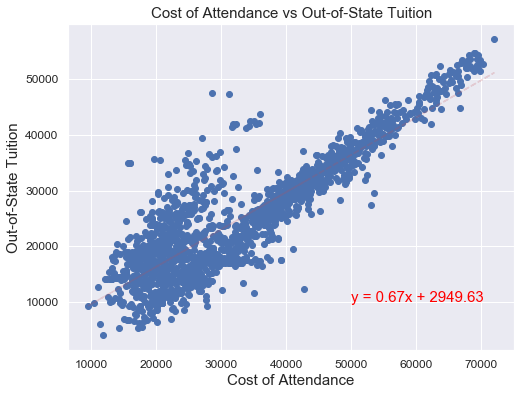

<Figure size 432x288 with 0 Axes>

In [39]:
# Calculate the correlation coefficient and linear regression model for Cost of Attendance and Out-of-State Tuition
one_df = csc_data_final['Cost of Attendance']
two_df = csc_data_final['Out-of-State Tuition']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(one_df,two_df)
y = regress_values = one_df * slope + intercept
print(regress_values)

# Create line equation 
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# Plot the linear model with scatter plot
plt.figure(figsize=(8,6))
plt.scatter(one_df, two_df)
f1 = plt.plot(one_df, regress_values, 'r--', alpha=0.2)

# Label plot and annotate the line equation
plt.annotate(line_eq,(50000,10000),fontsize=15,color="red")
plt.xlabel('Cost of Attendance', size=15)
plt.ylabel('Out-of-State Tuition', size=15)
plt.title('Cost of Attendance vs Out-of-State Tuition', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
print(f"The correlation between Cost of Attendance and  Out-of-State Tuition is: {rvalue}")

plt.show()
plt.savefig('outputs/CostOfAttendanceVSInStateTuition.png')

#### Correlation between 'Cost of Attendance' and 'Out-of-State Tuition'

0       30009.087586
1       13489.760935
2       24770.495081
3       13327.224860
4        9871.050443
            ...     
1608    32659.886616
1609    47779.394144
1610    36743.377235
1611    16166.127439
1612     8661.161116
Name: Cost of Attendance, Length: 1613, dtype: float64
y = 0.91x + -9249.77
The correlation between Cost of Attendance and  In-State Tuition is: 0.9777399144710648


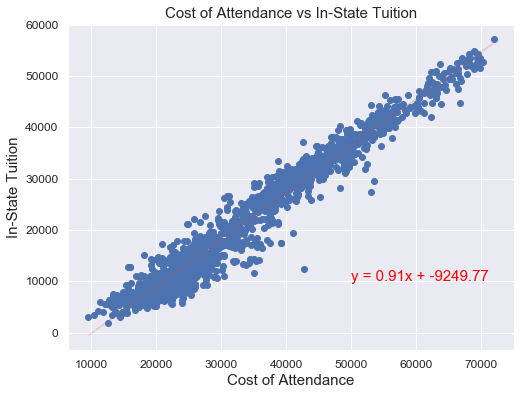

<Figure size 432x288 with 0 Axes>

In [35]:
# Calculate the correlation coefficient and linear regression model for Cost of Attendance and In-State Tuition
one1_df = csc_data_final['Cost of Attendance']
two1_df = csc_data_final['In-State Tuition']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(one1_df,two1_df)
y1 = regress_values = one1_df * slope + intercept
print(regress_values)

# Create line equation 
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# Plot the linear model with scatter plot
plt.figure(figsize=(8,6))
f2 = plt.scatter(one1_df, two1_df)
plt.plot(one1_df, regress_values, 'r--', alpha=0.2)

# Label plot and annotate the line equation
plt.annotate(line_eq,(50000,10000),fontsize=15,color="red")
plt.xlabel('Cost of Attendance', size=15)
plt.ylabel('In-State Tuition', size=15)
plt.title('Cost of Attendance vs In-State Tuition', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
print(f"The correlation between Cost of Attendance and  In-State Tuition is: {rvalue}")

plt.show()
plt.savefig('outputs/CostOfAttendanceVSOutofStateTuition.png')

The resulting data frame consists of 1747 observations. As seen from the scatterplot, a school’s Cost of Attendance is positively associated with its In-State Tuition and Out-of-State Tuition. This is consistent with what we hypothesized since it’s well understood that an increase of the Cost of Atttendace will generate an increase of the tuition as well.  The hight r-squarred of 0.89( and 0.97 respectivley for In State Tuition) confirm that this relationship has a significant correlation. The coefficients we obtained from this simple linear regression analysis using statsmodels package tell us that an increase of 10 000 points  in Cost of Attendance is associated with an increase in tuition by around 10 000 points as well.

#### Correlation between 'Cost of Attendance' and 'Median Debt with income greater than 75k'

0       17635.862292
1       14921.065878
2       16774.948742
3       14894.354598
4       14326.364745
            ...     
1608    18071.496253
1609    20556.245522
1610    18742.579640
1611    15360.901613
1612    14127.530781
Name: Cost of Attendance, Length: 1613, dtype: float64
y = 0.15x + 11184.04
The correlation between Cost of Attendance and  Median Debt with income greater than 75k is: 0.486500930456841


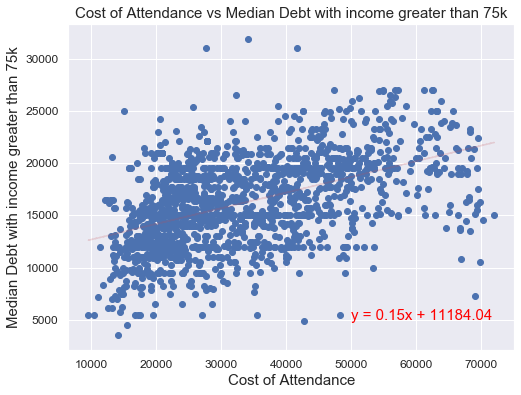

In [42]:
# Calculate the correlation coefficient and linear regression model for Cost of Attendance and Median Debt with income greater than 75k
one3_df = csc_data_final['Cost of Attendance']
two3_df = csc_data_final['Median Debt with income greater than 75k']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(one3_df,two3_df)
y3 = regress_values = one3_df * slope + intercept
print(regress_values)

# Create line equation 
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# Plot the linear model with scatter plot
plt.figure(figsize=(8,6))
plt.scatter(one3_df, two3_df)
plt.plot(one3_df, regress_values, 'r--', alpha=0.2)

# Label plot and annotate the line equation
plt.annotate(line_eq,(50000,5000),fontsize=15,color="red")
plt.xlabel('Cost of Attendance', size=15)
plt.ylabel('Median Debt with income greater than 75k', size=15)
plt.title('Cost of Attendance vs Median Debt with income greater than 75k', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
print(f"The correlation between Cost of Attendance and  Median Debt with income greater than 75k is: {rvalue}")
plt.savefig('outputs/CostofAttendanceVSMedianDebtwithIncomeGreaterThan75k.png')
plt.show()



I was interested to analyse the relation between 'Cost of Attendance' and  'Median Debt with income greater than 75k' because I thought that an increase in the Cost of Attendance will make easier the payment of debt for the upper class.
The low r-squared confirms that this relationship is correlation is non-significant.

#### Correlation between 'Cost of Attendance' and 'Completion Rate'

0       0.566278
1       0.437086
2       0.525309
3       0.435815
4       0.408785
          ...   
1608    0.587009
1609    0.705253
1610    0.618944
1611    0.458017
1612    0.399323
Name: Cost of Attendance, Length: 1613, dtype: float64
y = 0.0x + 0.26
The correlation between Cost of Attendance and Completion Rate is: 0.5209217356398815


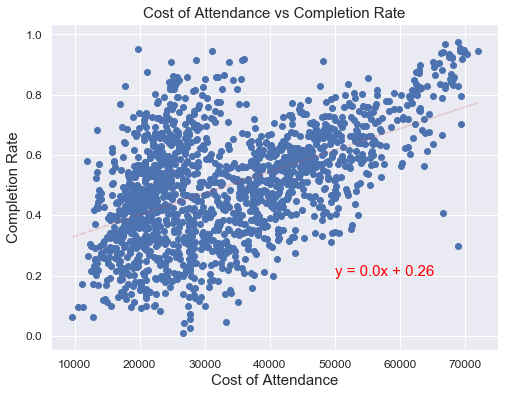

In [43]:
# Calculate the correlation coefficient and linear regression model for Cost of Attendance and Out-of-State Tuition
one_df = csc_data_final['Cost of Attendance']
two_df = csc_data_final['Completion Rate']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(one_df,two_df)
y = regress_values = one_df * slope + intercept
print(regress_values)

# Create line equation 
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# Plot the linear model with scatter plot
plt.figure(figsize=(8,6))
plt.scatter(one_df, two_df)
f1 = plt.plot(one_df, regress_values, 'r--', alpha=0.2)

# Label plot and annotate the line equation
plt.annotate(line_eq,(50000,0.2),fontsize=15,color="red")
plt.xlabel('Cost of Attendance', size=15)
plt.ylabel('Completion Rate', size=15)
plt.title('Cost of Attendance vs Completion Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
print(f"The correlation between Cost of Attendance and Completion Rate is: {rvalue}")
plt.savefig('outputs/CostOfAttendanceVSCompletionRate.png')
plt.show()

The correlation between Cost of Attendance and Completion Rate is: 0.52. An increase of the Cost of Attendance will generate an increase for the Completition Rate. Probably, not the best conclusion.
Also,from the scattter plot we can see 2 different groups formed. I can concide that there are probably, individuals who will complete their degree with a lower Cost of Attendance(around  20000 -40000). And the second group of individuals who will graduate even eith a higher Cost of Attendance.

# Conclusion:

- Today’s Americans are more educated than ever before
- There are more Female then Male having a student debt.
- Individual within the range of age of 31-50 have the higher amount of debt to pay.
- The states with a high amount of Total Debt, but with an increasing population as weel, will result with a lower amount of debt per capita.Ans vice-versa, for the states with a low volume of population will have a higher amount of debt per capita.

### Ana's Code - End

----------------------------------------------

### Vikash's Code - Start

In [ ]:
!mkdir outputs
!ls -ltr outputs/

In [ ]:
profile = ProfileReport(csc_data_final, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [ ]:
profile.to_notebook_iframe()

In [ ]:
profile.to_file(output_file="outputs/vk_report.html")

In [ ]:
loanDF = csc_data_final

In [ ]:
# find list of columns which has more than 50% of data missing.
def findMissingValueCols(df):
    #df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    missingValueColumns = []
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        print(column, "--", nullRows)
        if nullRows > loanDFRows*0.5 : # i.e. if ALL values are NULL
            missingValueColumns.append(column)
    return missingValueColumns

# columns names which has more than 50% data missing
#missingValueColList = findMissingValueCols(loanDF)

#print(missingValueColList)

In [ ]:
loanCoA = loanDF[["Cost_of_Attendance"]].astype('float')
loanCoA.head()

In [ ]:
loanCoA = loanDF[["Cost_of_Attendance"]].astype('float')
sns.distplot(loanCoA, fit=stats.gamma, axlabel="Cost_of_Attendance", label="Cost_of_Attendance distribution")

In [ ]:
sns.boxplot(loanCoA)

In [ ]:
loanCR = loanDF[["Completion_Rate"]].astype('float')
sns.distplot(loanCR, fit=stats.gamma, axlabel="Completion_Rate", label="Completion_Rate distribution")

In [ ]:
sns.boxplot(loanCR)

In [ ]:
fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
# Cost_of_Attendance distribution plots
sns.distplot(loanCoA, fit=stats.gamma, axlabel="Cost_of_Attendance", label="Cost_of_Attendance distribution", ax=ax[0][0])
sns.boxplot(x=loanCoA.Cost_of_Attendance, ax=ax[0][1])

# Completion_Rate distribution plots
sns.distplot(loanCR, fit=stats.gamma, axlabel="Completion_Rate", label="Completion_Rate distribution", ax=ax[1][0])
sns.boxplot(x=loanCR.Completion_Rate, ax=ax[1][1])

fig.show()
plt.savefig("outputs/vk_Cost_of_Att_and_Completion_Rate.png")


In [ ]:
from scipy import stats

In [ ]:
x_values = csc_data_final["Median_Debt_for_Female_Students"]
y_values = csc_data_final['Median_Debt_for_Male_Students']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Median_Debt_for_Female_Students')
plt.ylabel('Median_Debt_for_Male_Students)')
print(f"The r-squared is: {rvalue}")
plt.savefig("outputs/vk_Median_Debt_for_Female_and_Male.png")
plt.show()

In [ ]:
x_values = csc_data_final["Completion_Rate"]
y_values = csc_data_final['Cost_of_Attendance']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1,10),fontsize=15,color="red")
plt.xlabel('Completion_Rate')
plt.ylabel('Cost_of_Attendance)')
print(f"The r-squared is: {rvalue}")
plt.savefig("outputs/vk_Completion_Rate_Cost_of_Attendance.png")
plt.show()


In [ ]:
x_values = csc_data_final["In-State_Tuition"]
y_values = csc_data_final['Cost_of_Attendance']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1,10),fontsize=15,color="red")
plt.xlabel('In-State_Tuition')
plt.ylabel('Cost_of_Attendance')
print(f"The r-squared is: {rvalue}")
plt.savefig("outputs/vk_In-State_Tuition_Cost_of_Attendance.png")
plt.show()


In [ ]:
x_values = csc_data_final["Median_Debt_for_Female_Students"]
y_values = csc_data_final['Median_Debt_with_income_between_30,001-75k']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1,20),fontsize=15,color="red")
plt.xlabel('Median_Debt_for_Female_Students')
plt.ylabel('Median_Debt_with_income_between_30,001-75k')
print(f"The r-squared is: {rvalue}")
plt.savefig("outputs/vk_Median_Debt_for_Female_Students_Median_Debt_with_income_between_30k-75k.png")
plt.show()


In [ ]:
x_values = csc_data_final["Median_Debt_with_income_between_0-30k"]
y_values = csc_data_final['Median_Loan_Principal']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1,20),fontsize=15,color="red")
plt.xlabel('Median_Debt_with_income_between_0-30k')
plt.ylabel('Median_Loan_Principal')
print(f"The r-squared is: {rvalue}")
plt.savefig("outputs/vk_Median_Debt_with_income_between_0-30k_Median_Loan_Principal.png")
plt.show()


In [ ]:
dd = csc_data_final[["State_Name", "Student_Size"]]
fig, ax =plt.subplots(3,1,figsize=(30,50))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="State_Name", data=dd,ax=ax[0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

s1 = sns.boxplot(x="State_Name", y="Student_Size", data=dd,ax=ax[1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)

s2 = sns.violinplot(x="State_Name", y="Student_Size", data=dd,ax=ax[2] , estimator=sum)
s2.set_xticklabels(s2.get_xticklabels(),rotation=45)

plt.savefig("outputs/vk_Student_Size3.png")
plt.show()

In [ ]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    
    #plt.show()

In [ ]:
univariate(df=csc_data_final,col='Cost_of_Attendance',vartype=0)
plt.savefig("outputs/vk_Cost_of_Attendance.png")
plt.show()

In [ ]:
univariate(df=csc_data_final,col='Student_Size',vartype=0)
plt.savefig("outputs/vk_Student_Size.png")
plt.show()

In [ ]:
univariate(df=csc_data_final,col='Completion_Rate',vartype=0)
plt.savefig("outputs/vk_Completion_Rate.png")
plt.show()

In [ ]:
loan_data = csc_data_final[["Cost_of_Attendance", "In-State_Tuition", "Completion_Rate", "Median_Debt_for_Female_Students" , "Median_Debt_with_income_between_30,001-75k", "Median_Loan_Principal", "Median_Debt_for_Male_Students", "Median_Debt_with_income_between_0-30k"]]
loan_data.head()

In [ ]:
loan_correlation = loan_data.corr()
loan_correlation.head()

In [ ]:
sns_plot = sns.clustermap(loan_correlation, cmap="Blues", 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True, robust=True)
plt.show()
sns_plot.savefig("outputs/vk_correlation.png")

### Vikash's Code - End